In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "EIE3280_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
# get data
train_data = pd.read_csv('dataset/movie_metadata.csv')
train_data_senti = pd.read_csv('sentiment.csv')
train_data_senti = train_data_senti.rename(columns = {'sentiment polarity': 'senti_director'})
train_data_senti = train_data_senti.rename(columns = {'count': 'count_director'})

train_data_senti_2 = pd.read_csv('ActorSentiment.csv')
train_data_senti_2 = train_data_senti_2.rename(columns = {'sentiment': 'senti_actor'})
train_data_senti_2 = train_data_senti_2.rename(columns = {'count': 'count_actor'})
train_data_senti_2 = train_data_senti_2.rename(columns = {'actor': 'actor_1_name'})

train_data_senti_3 = pd.read_csv('comment_senti.csv')

# check the data
train_data.head()
train_data_senti.head()
train_data_senti_2.head()
train_data_senti_3.head()

FileNotFoundError: [Errno 2] File b'movie_metadata.csv' does not exist: b'movie_metadata.csv'

In [ ]:
# check the data info
train_data.info()
train_data_senti.info()
train_data_senti_2.info()
train_data_senti_3.info()

In [30]:
# clean sentiment data
train_data_senti.drop_duplicates('director', 'first', inplace = True)
train_data_senti = train_data_senti[~train_data_senti['director'].isin(['director'])]

train_data_senti_2.drop_duplicates('actor_1_name', 'first', inplace = True)
train_data_senti_2 = train_data_senti_2[~train_data_senti_2['actor_1_name'].isin(['actor_1_name'])]

del train_data_senti_3['index']

train_data_senti.head()
train_data_senti_2.head()
train_data_senti_3.head()

,senti_comment
0,0.182644
1,0.151764
2,0.141950
3,0.101435
4,-0.003392


In [31]:
# combine the train data and sentiment data
train_data = pd.merge(train_data, train_data_senti, on = 'director', how = 'left')
train_data = pd.merge(train_data, train_data_senti_2, on = 'actor_1_name', how = 'left')
train_data['senti_comment'] = train_data_senti_3

train_data['senti_comment'] = train_data['senti_comment'].replace(0, np.nan)

# change data type
train_data[['senti_director', 'count_director']] = train_data[['senti_director', 'count_director']].astype(float)
# get the avg
senti_avg = train_data['senti_director'].mean()
count_avg = train_data['count_director'].mean()

senti_avg_actor = train_data['senti_actor'].mean()
count_avg_actor = train_data['count_actor'].mean()

comment_avg = train_data['senti_comment'].mean()
# fill the missing data
train_data['senti_director'] = train_data['senti_director'].replace(np.nan, senti_avg)
train_data['count_director'] = train_data['count_director'].replace(np.nan, count_avg)
train_data['senti_actor'] = train_data['senti_actor'].replace(np.nan, senti_avg_actor)
train_data['count_actor'] = train_data['count_actor'].replace(np.nan, count_avg_actor)
train_data['senti_comment'] = train_data['senti_comment'].replace(np.nan, comment_avg)
train_data.head()

,color,director,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,senti_director,count_director,senti_actor,count_actor,senti_comment
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,2009.0,936.0,7.9,1.78,33000,0.171308,120.000000,0.107394,20.000000,0.182644
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,2007.0,5000.0,7.1,2.35,0,0.062750,20.000000,0.078728,462.000000,0.151764
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,2015.0,393.0,6.8,2.35,85000,0.198971,420.000000,0.111401,494.000000,0.141950
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2012.0,23000.0,8.5,2.35,164000,0.112011,500.000000,0.089904,496.000000,0.101435
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,12.0,7.1,NaN,0,0.110234,198.330193,0.132119,284.745601,-0.003392


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128a23710>,
      dtype=object)

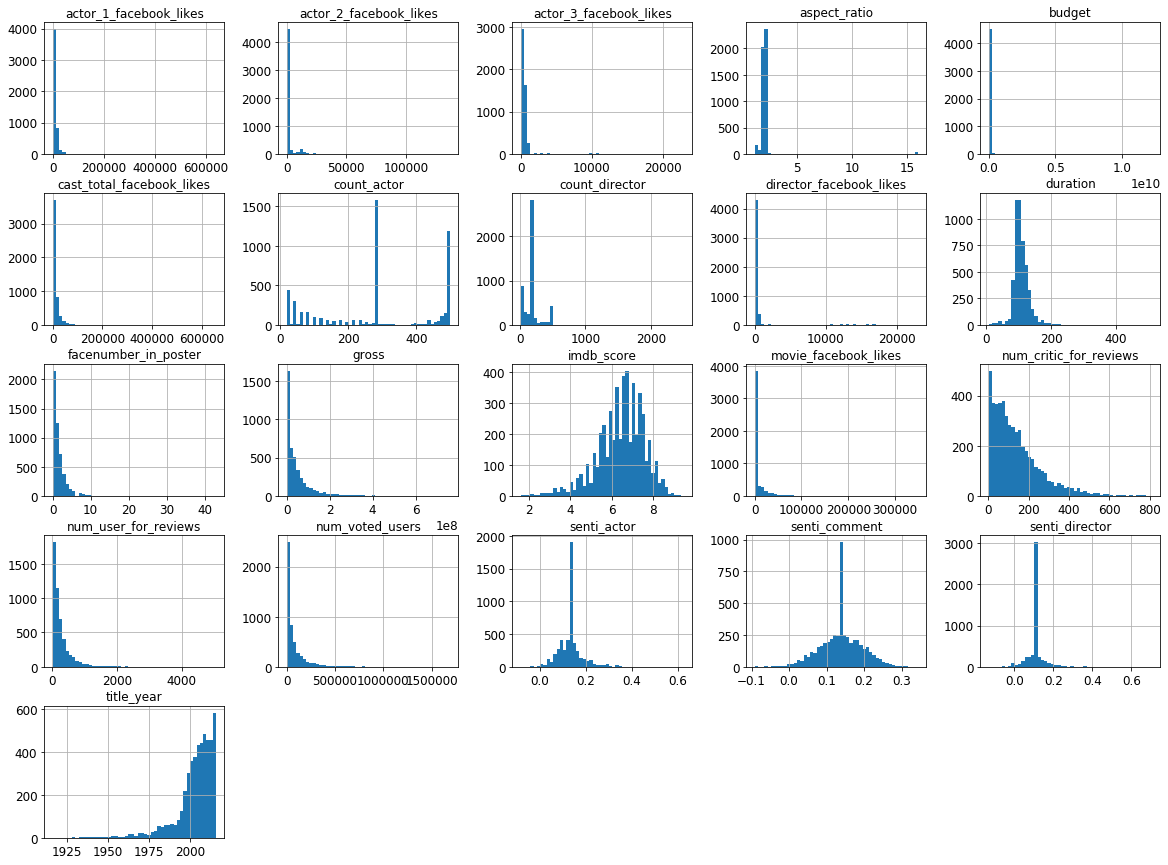

In [32]:
# data insight to see the relavance
train_data.columns
train_data.hist(bins=50, figsize=(20,15))

In [33]:
# data describe
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 5042
Data columns (total 33 columns):
color                        5024 non-null object
director                     4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

In [8]:
# change the country to data
#train_data[['country']] = train_data[['country']].astype(str)
#v_country = train_data.country
#LabelEncoder().fit_transform(train_data[['country']])
#print(v_country)
#print(train_data.country.shape)
#print(train_data.country.reshape(-1,1).shape)
#v_country = OneHotEncoder(sparse = False).fit_transform(train_data.country.reshape(-1,1))
#print(v_country)
#train_data[['country']]

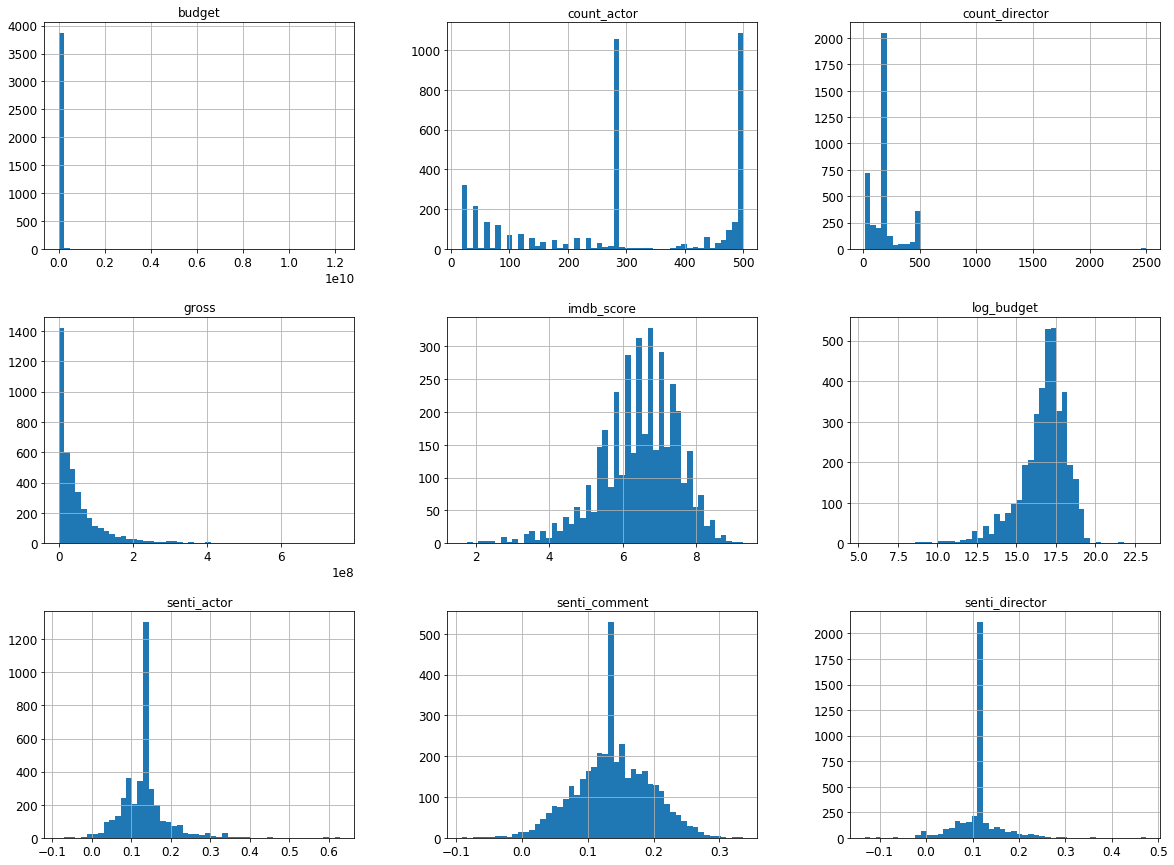

In [34]:
# get the train data attribute for prediction
train_data_pred = train_data[['gross', 'budget', 'senti_actor', 'senti_director', 'country', 'genres', 'imdb_score', 'count_actor', 'count_director', 'senti_comment']]
train_data_pred = train_data_pred.dropna()
train_data_pred.reset_index(drop=True)
train_data_pred["log_budget"] = np.log(train_data_pred["budget"])
train_data_pred.hist(bins=50, figsize=(20,15))
plt.show()

In [35]:
# change the genres to data
# cut the genres
genres_n = pd.Series(train_data_pred.genres)
genres_n = genres_n.str.split('|')
genres_n = genres_n.str.get(0)
train_data_pred['genres'] = genres_n
train_data_pred.head()

,gross,budget,senti_actor,senti_director,country,genres,imdb_score,count_actor,count_director,senti_comment,log_budget
0,760505847.0,237000000.0,0.107394,0.171308,USA,Action,7.9,20.000000,120.0,0.182644,19.283571
1,309404152.0,300000000.0,0.078728,0.062750,USA,Action,7.1,462.000000,20.0,0.151764,19.519293
2,200074175.0,245000000.0,0.111401,0.198971,UK,Action,6.8,494.000000,420.0,0.141950,19.316769
3,448130642.0,250000000.0,0.089904,0.112011,USA,Action,8.5,496.000000,500.0,0.101435,19.336971
5,73058679.0,263700000.0,0.132119,0.474118,USA,Action,6.6,284.745601,40.0,0.219712,19.390323


In [36]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_data_pred, test_size=0.2, random_state=42)
corr_matrix = train_data_pred.corr()
corr_matrix

,gross,budget,senti_actor,senti_director,imdb_score,count_actor,count_director,senti_comment,log_budget
gross,1.000000,0.102179,-0.059372,-0.038647,0.211525,0.157686,0.130619,0.087834,0.458518
budget,0.102179,1.000000,-0.008357,0.006886,0.029135,0.028756,0.011627,-0.004895,0.253187
senti_actor,-0.059372,-0.008357,1.000000,0.012217,-0.005943,-0.084837,-0.044898,0.044841,-0.056768
senti_director,-0.038647,0.006886,0.012217,1.000000,0.001360,-0.028654,-0.123663,0.036673,-0.019571
imdb_score,0.211525,0.029135,-0.005943,0.001360,1.000000,0.094144,0.094044,0.363027,-0.053026
count_actor,0.157686,0.028756,-0.084837,-0.028654,0.094144,1.000000,0.058934,-0.021740,0.183884
count_director,0.130619,0.011627,-0.044898,-0.123663,0.094044,0.058934,1.000000,-0.014114,0.059175
senti_comment,0.087834,-0.004895,0.044841,0.036673,0.363027,-0.021740,-0.014114,1.000000,0.043470
log_budget,0.458518,0.253187,-0.056768,-0.019571,-0.053026,0.183884,0.059175,0.043470,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12da79e80>,
      dtype=object)

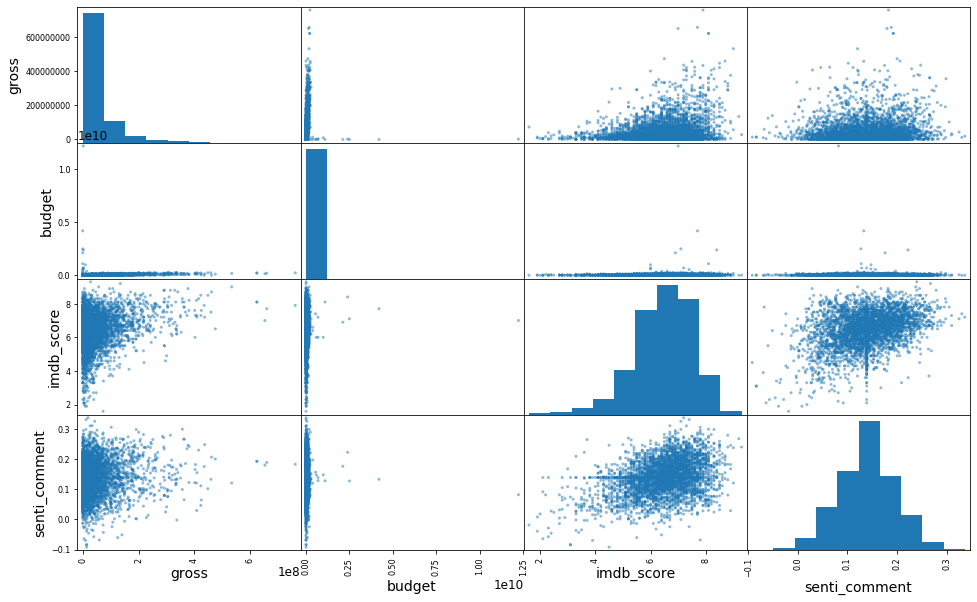

In [37]:
from pandas.plotting import scatter_matrix
attributes = ['gross', 'budget', 'country', 'genres', 'imdb_score', 'senti_comment']
scatter_matrix(train_data_pred[attributes], figsize=(16,10))

In [38]:
train_set = train_set.reset_index(drop=True)
train_set["log_gross"] = np.log(train_set["gross"])
train_set.drop(["gross", "budget"], axis=1, inplace=True)
movies_tr_labels = train_set["log_gross"].copy()
movies_tr = train_set.drop("log_gross",axis=1)
movies_tr.head()

,senti_actor,senti_director,country,genres,imdb_score,count_actor,count_director,senti_comment,log_budget
0,0.142693,0.061010,USA,Biography,7.9,437.0,20.000000,0.182746,17.034386
1,0.215417,0.052866,USA,Comedy,5.7,20.0,100.000000,0.101636,15.894952
2,0.136740,0.110234,USA,Adventure,6.5,495.0,198.330193,0.198079,18.720785
3,0.078728,0.101626,USA,Biography,7.0,462.0,269.000000,0.120571,18.420681
4,0.146906,0.122245,USA,Action,6.3,491.0,60.000000,0.170495,17.622173


In [39]:
# dump selected attributes metadata
movies_tr.to_csv('/Users/endlessio/Desktop/box-office-predictor-master/attr_metadata.csv')

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_attribs_country = ["country"]
cat_attribs_genres = ["genres"]
num_attribs = list(movies_tr.drop(cat_attribs, axis=1))

print("num\n", num_attribs)

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
full_pipeline_c = ColumnTransformer([
        ("num", num_pipeline, num_attribs_country),
        ("cat_c", OneHotEncoder(), cat_attribs_country),
    ])
full_pipeline_g = ColumnTransformer([
        ("num", num_pipeline, num_attribs_genres),
        ("cat_g", OneHotEncoder(), cat_attribs_genres),
    ])

movies_tr_preprocessing_c = full_pipeline_c.fit_transform(train_set)# Using the full data rather than train data
movies_tr_pre
movies_tr_prepared = movies_tr_preprocessing

num
 ['senti_actor', 'senti_director', 'imdb_score', 'count_actor', 'count_director', 'log_budget']


In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(movies_tr_prepared, movies_tr_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.4)
elastic_net.fit(movies_tr_prepared, movies_tr_labels)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(movies_tr_prepared, movies_tr_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [19]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(movies_tr_prepared, movies_tr_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
def show_some_predictions(model):
    some_data = movies_tr.iloc[-5:]
    some_labels = movies_tr_labels.iloc[-5:]
    some_data_prepared = full_pipeline.transform(some_data)
    print("Predictions:\t", model.predict(some_data_prepared))
    print("Labels:\t\t", list(some_labels))

In [21]:
from sklearn.model_selection import cross_val_score

def display_scores(model):
    scores = cross_val_score(model, movies_tr_prepared, movies_tr_labels, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores)
    result_info = '''
    Scores: {scores}
    Mean: {mean}
    Standard deviation: {std}
    **********************************************
    '''.format(scores=rmse_scores, mean=rmse_scores.mean(), std=rmse_scores.std())
    print(result_info)
    return result_info

In [22]:
import json

def writeJson(json_path, data):
    '''Overwrite or add the infomation into original json file.

    PARAM:
    `json_path`: the path of the json file
    `data`: the data you wanna add or write in the form of dictionary
    '''
    if type(data) == dict:
        key_list = list(data.keys())
        try:
            with open(json_path, "r") as jsonFile:
                origin = json.load(jsonFile)
            for i in key_list:
                origin[i] = data[i]
            with open(json_path, 'w') as jsonFile:
                jsonObj = json.dumps(origin)
                jsonFile.write(jsonObj)
        except:
            with open(json_path, 'w') as jsonFile:
                jsonObj = json.dumps(data)
                jsonFile.write(jsonObj)
    elif type(data) == list:
        with open(json_path, 'w') as jsonFile:
            jsonObj = json.dumps(data)
            jsonFile.write(jsonObj)
            
def dump_results(**kargs):
    dit = {}
    for k,i in kargs.items():
        dit[k] = display_scores(i)
    writeJson("/Users/endlessio/Desktop/box-office-predictor-master/attr_model_rmse_scores.json", dit)

dump_results(LinearRegression=lin_reg, ElasticNet=elastic_net, DecisionTree=tree_reg, RandomForest=forest_reg)


    Scores: [1.58130815 1.68932431 1.75943457 1.66336607 1.63086347]
    Mean: 1.6648593137637557
    Standard deviation: 0.0594672325096682
    **********************************************
    

    Scores: [1.62742027 1.72709662 1.79720498 1.72032163 1.6972205 ]
    Mean: 1.7138527987402128
    Standard deviation: 0.05461143834333857
    **********************************************
    

    Scores: [2.08811637 2.22136511 2.20303357 2.08665801 2.22306753]
    Mean: 2.164448118884814
    Standard deviation: 0.06331264068431583
    **********************************************
    

    Scores: [1.64190394 1.73159843 1.62318093 1.70293851 1.54055683]
    Mean: 1.648035730045373
    Standard deviation: 0.06663949800074834
    **********************************************
    


In [23]:
import datetime
timeStart = datetime.datetime.now()
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint           
param_distribs = [{
        'n_estimators': [5*(i+1) for i in range(20)],
        'max_features': [2*(i+1) for i in range(5)],
        'min_samples_leaf': [1,2,3,4],
        'oob_score':[True]}
]
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = GridSearchCV(forest_reg, param_grid=param_distribs,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=3)
rnd_search.fit(movies_tr_prepared, movies_tr_labels)
timeEnd = datetime.datetime.now()
print(str(timeEnd-timeStart)) 
np.sqrt(-rnd_search.best_score_)

0:04:26.540278


1.5712835794387048

In [24]:
best_rnd_forest_model = rnd_search.best_estimator_ 

In [25]:
from sklearn.externals import joblib
joblib.dump(best_rnd_forest_model, "./model_instance/log_gross.pkl")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['./model_instance/log_gross.pkl']

In [26]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0]) + LI
attributes = num_attribs + cat_one_hot_attribs
feature_importances = rnd_search.best_estimator_.feature_importances_
importances_vs_features=sorted(zip(feature_importances, attributes), reverse=True, key=lambda x:x[0])
importances_vs_features

[(0.3524234888445023, 'log_budget'),
 (0.12676486839956427, 'imdb_score'),
 (0.09381824422593515, 'count_actor'),
 (0.0852424397401425, 'senti_actor'),
 (0.060945032063774204, 'senti_director'),
 (0.05178873506838731, 'USA'),
 (0.05103666924533457, 'count_director'),
 (0.010020047314690687, 'UK'),
 (0.00908611021047566, 'France'),
 (0.006138143660667233, 'China'),
 (0.0054045871708493665, 'Germany'),
 (0.004004000285148456, 'Canada'),
 (0.003070688859844747, 'Belgium'),
 (0.002741548895474676, 'India'),
 (0.0027409764026513433, 'Spain'),
 (0.002634881988331251, 'Japan'),
 (0.002615007491318189, 'Iceland'),
 (0.002390644842192305, 'Italy'),
 (0.0022053437540386243, 'Sweden'),
 (0.0021612861739191366, 'Australia'),
 (0.00202590024421953, 'Georgia'),
 (0.001983441313744478, 'South Korea'),
 (0.001951433425324695, 'South Africa'),
 (0.0018547467188294847, 'Denmark'),
 (0.0017271019702769948, 'Hong Kong'),
 (0.0011149802453102133, 'Norway'),
 (0.0010000378298930682, 'Mexico'),
 (0.000803403